In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from os import path
import json
from ast import literal_eval
from public_MAPE import score_function
from time import time
import matplotlib.pyplot as plt
import matplotlib

plt.style.use("bmh")
matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)
all_colors = [parameter['color'] for parameter in plt.rcParams['axes.prop_cycle']]

In [3]:
data_dir = "data"

train = pd.read_csv(path.join(data_dir, "train_input.csv"), sep=';', index_col=0)
ages = pd.read_csv(path.join(data_dir, "train_output.csv"), sep=';', index_col=0)

In [32]:
id_18 = 479
id_28 = 533
id_38 = 127
id_48 = 217
id_58 = 236
id_68 = 298
idxs = [id_18, id_28, id_38, id_48, id_58, id_68]
ag = ["18", "28", "38", "48", "58", "68"]

In [68]:
samples = train.iloc[idxs, 1:-1].values

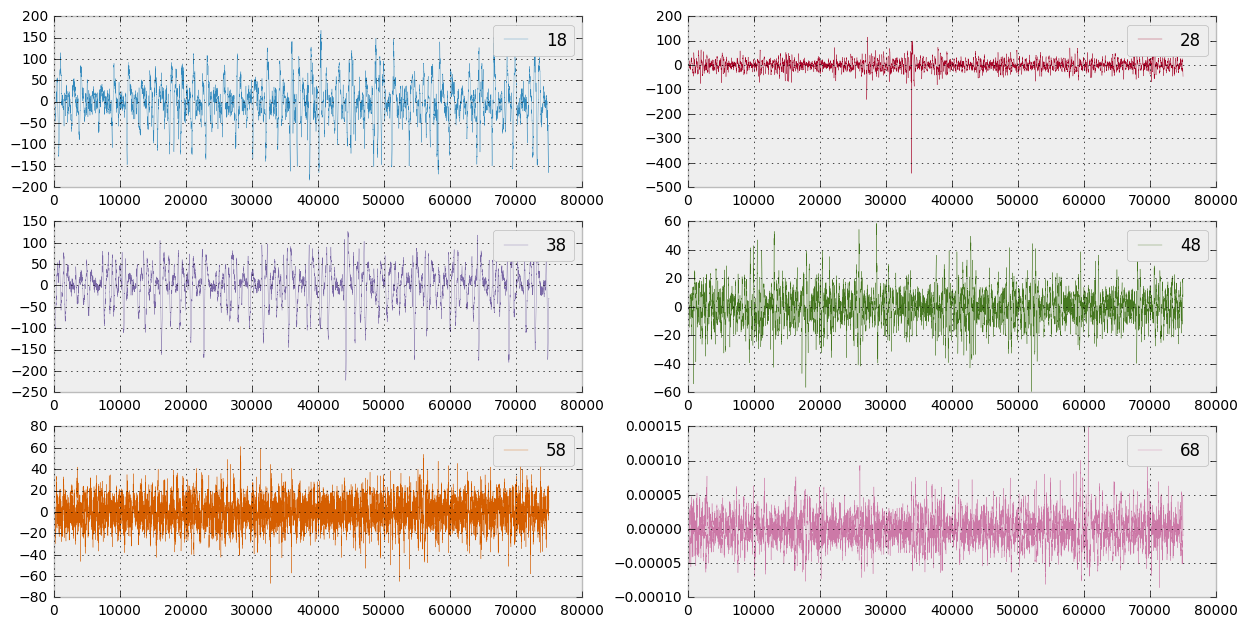

In [75]:
f, axs = plt.subplots(3, 2)
for row in range(3):
    for col in range(2):
        idx = col + 2*row
        axs[row, col].plot(samples[idx, :], linewidth=0.25, color=all_colors[idx], label=ag[idx])
        axs[row, col].legend()
# plt.plot(sample, linewidth=0.5)
plt.savefig(path.join("figures", "EGG_all_ages.png"), format="png")

In [17]:
from scipy.fftpack import fft
from scipy.signal import blackman
freq = 250
T = 1./freq
N = 75000
middle_N = int(N/2)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


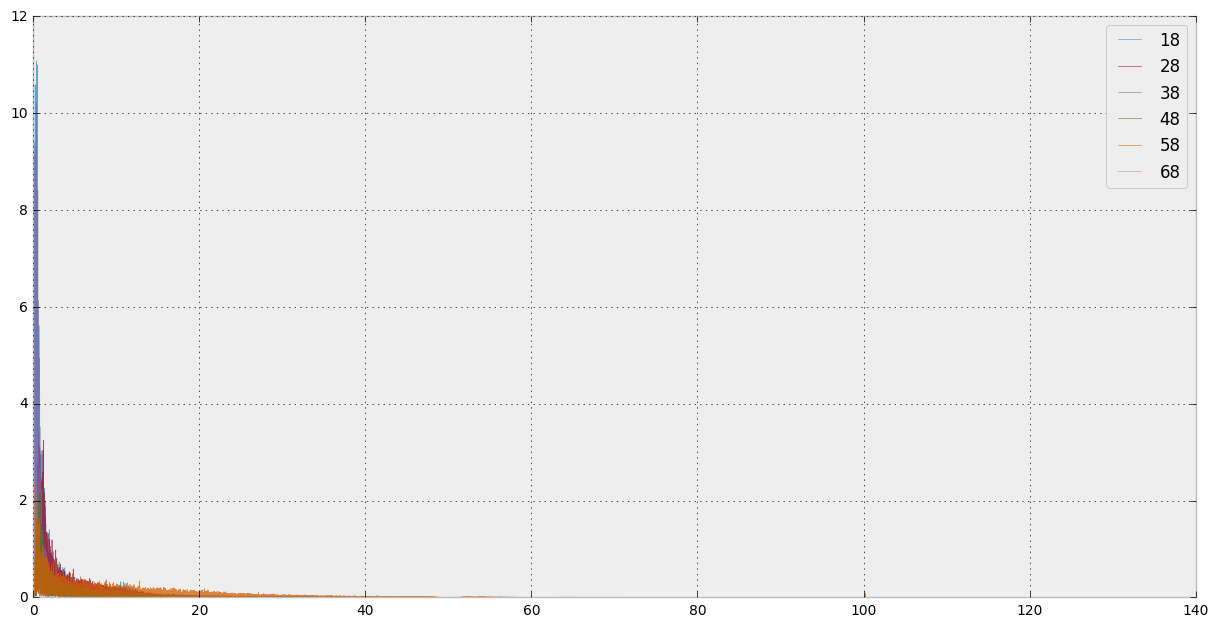

In [78]:
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
for idx in range(6):
    yf = fft(samples[idx, :])
    plt.plot(xf, 2.0/N * np.abs(yf[0:N/2]), linewidth=0.5, alpha=0.75, color=all_colors[idx], label=ag[idx])
plt.axis("auto")
plt.legend()
# plt.savefig(path.join("figures", "FFT_56.png"), format="png")

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


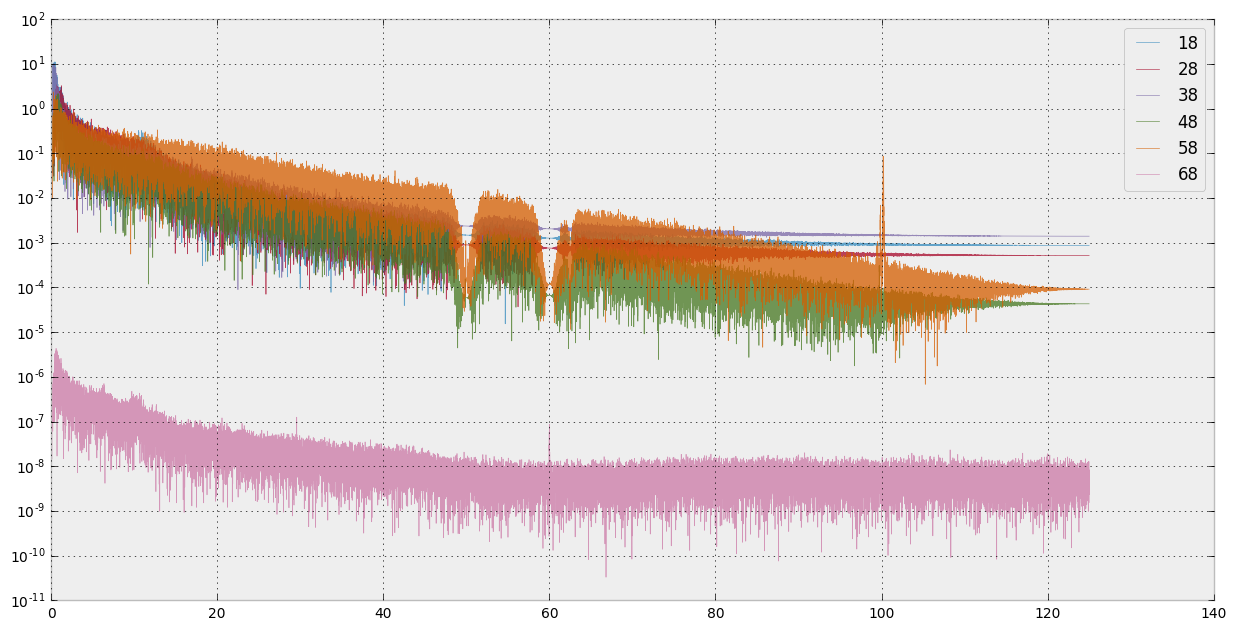

In [82]:
# cut = np.where(xf >= 80)[0][0]
cut = 1
for idx in range(6):
    yf = fft(samples[idx, :])
    plt.semilogy(xf[cut:N/2], 2.0/N * np.abs(yf[cut:N/2]), linewidth=0.5, color=all_colors[idx], alpha=0.75, label=ag[idx])
plt.axis("auto")
plt.legend()
plt.savefig(path.join("figures", "FFT_semilog_all.png"), format="png")

In [11]:
EEG = train.iloc[:, 1:-1]

In [15]:
def get_spectre(row):
    global N
    yf = fft(row)
    ampl = 2.0/N * np.abs(yf)
    return ampl

In [18]:
FFT = EEG.apply(get_spectre, axis=1).iloc[:,:middle_N]

In [40]:
FFT["BINS"] = 10*((ages - 8) // 10) + 8
FFT["BINS"] = FFT["BINS"].replace(68, 58)

In [42]:
FFT_mean = FFT.groupby("BINS").mean()

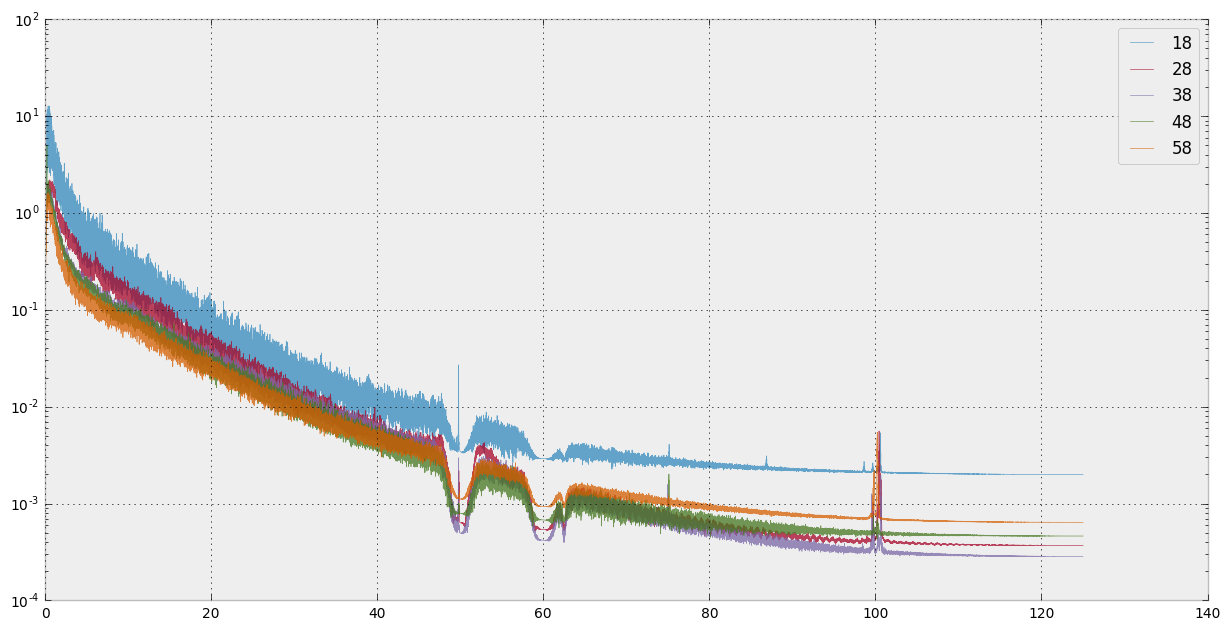

In [44]:
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
# cut = np.where(xf >= 80)[0][0]
cut = 1
ags = list(FFT_mean.index)
for idx, age in enumerate(ags):
    ampl = FFT_mean.loc[age,:].values
    plt.semilogy(xf[cut:middle_N], ampl[cut:], linewidth=0.5, color=all_colors[idx], alpha=0.75, label=age)
plt.axis("auto")
plt.legend()
plt.savefig(path.join("figures", "FFT_semilog_all.png"), format="png")

In [45]:
FFT["BINS"].value_counts()

38    180
18    135
28    120
48     90
58     56
Name: BINS, dtype: int64